# Bayesian Directional Forecasting on US/EU Stocks
The goal in quantitative finance is to forecast the price movement across a breadth of
assets, which is hard because of the efficient market hypothesis. We'll use edward, a probabilistic programming framework from Blei Labs, for the modeling/inference/criticism.

## Supervised Learning (Classification)
The task is supervised learning, where we infer hidden structure from labeled data, comprised of training examples $\{(x_n, y_n)\}$. Classification means the output $y$ takes discrete values.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ed.set_seed(42)

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [2]:
# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')
from inference import IWVI
from dataset import DataSet
from data import *
from helpers import *

This notebook, like edward, is organized around Box's Loop.   

![alt text](https://am207.github.io/2017/wiki/images/boxloop.png "George EP Box")

### DATA

To forecast asset excess price movements, we'll will analyze a truncated version of a preprocessed and
handcrafted dataset $X$ (aligned dimensions: 50 x 25000) that according to experts in the field
holds higher candidacy for predictive power.

Our target $y$ being 1 (when price movement is Up) or 0 (Down). The target data is balanced.

In [3]:
dataset = DataSet(pca_comps=range(0,50), frac=1, balance=True)
X_data, y_data, X_test, y_test = dataset.get_train_and_val()
print('shapes (X_data,y_data),', X_data.shape, y_data.shape)
print('dataset is balanced: y.mean =', y_data.mean())

D = X_data.shape[1]

Shapes:
X_data: (24996, 50)
x_test: (10001, 50)
shapes (X_data,y_data), (24996, 50) (24996,)
dataset is balanced: y.mean = 0.5


target    1.000000
3         0.042838
19        0.036659
2         0.035413
6         0.028047
1         0.027553
0         0.027338
22        0.025611
31        0.025386
45        0.023501
Name: target, dtype: float64

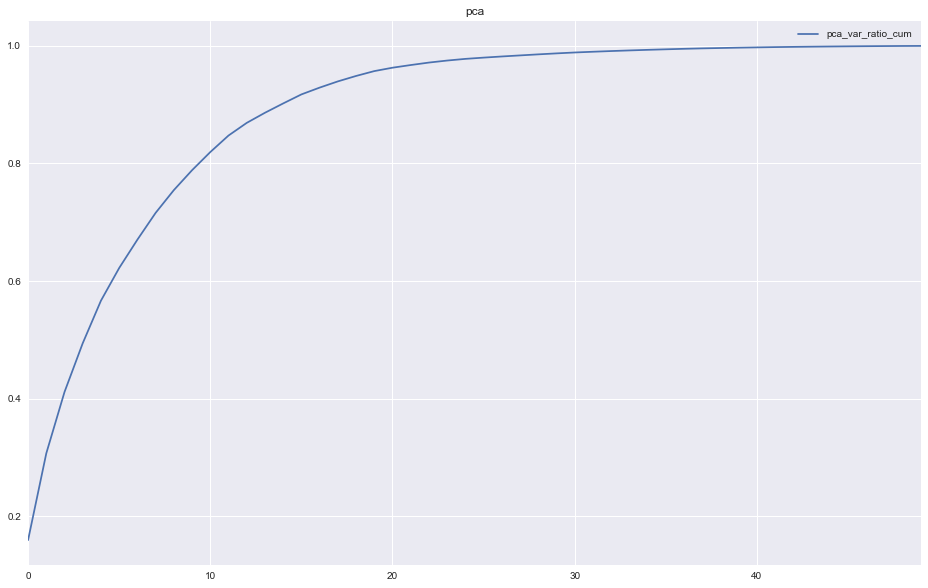

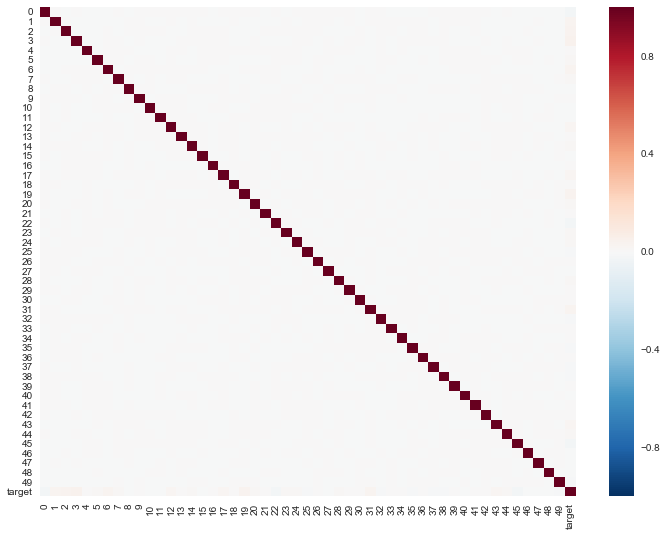

In [4]:
fig = plt.figure(figsize=(12, 9))

pca_cum_var_expl = pd.DataFrame({'pca_var_ratio_cum':dataset.pca.explained_variance_ratio_}).cumsum()
ax = pca_cum_var_expl.plot(title='pca')

fig = plt.figure(figsize=(12, 9))

df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());

abs(df.corr()['target']).sort_values(ascending=False).head(10)

The dataset has zero correlation and we choose to keep every PCA component. Below you'll see the 'blob' plot of the top three components (ranked by abs correlation) with no obvious plane of seperation. This is a visual to showcase the high noise, low signal nature of this dataset.

In [ ]:
most_corr_components = abs(df.corr()['target']).sort_values(ascending=False).head(10).index[1:].tolist()

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.scatter(X_data[:, most_corr_components[0]], 
           X_data[:, most_corr_components[1]], 
           X_data[:,most_corr_components[2]], c=y_data, alpha=.5,
          );
ax.set_title(str(most_corr_components[0:3]));

![daf](https://user-images.githubusercontent.com/1789890/33452562-8d5fe61c-d60a-11e7-8ea0-6beb8d427f1c.png "dataset")

### MODEL

A simple Bayesian logistic regression

In [6]:
X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D)*10)
b = Normal(loc=tf.zeros(1), scale=tf.ones(1)*10)
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

In [7]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss
sess = get_session()

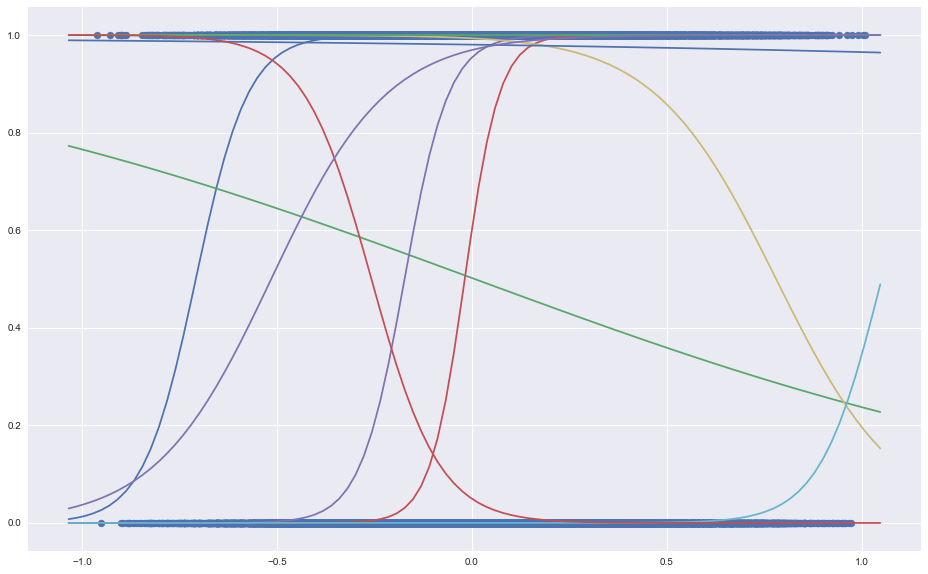

In [8]:
ww = visualise(X_data, y_data, w, b) #prior samples

We use KLqp Variation Inference with batch learning. We use 5 latent variable samples for computing black box stochastic gradients in the algorithm. 

A Monte Carlo estimate of the ELBO gradient is
$$\begin{aligned} \nabla_\lambda\; \text{ELBO}(\lambda) &\approx\; \frac{1}{S} \sum_{s=1}^{S} \big[ \nabla_\lambda \big( \log p(\mathbf{x}, \mathbf{z}(\epsilon_s \;;\; \lambda)) - \log q(\mathbf{z}(\epsilon_s \;;\; \lambda) \;;\;\lambda) \big) \big].\end{aligned}$$

This is an unbiased estimate of the actual gradient of the ELBO. Empirically, it exhibits lower variance than the score function gradient, leading to faster convergence in a large set of problems.

384/384 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 17215.277


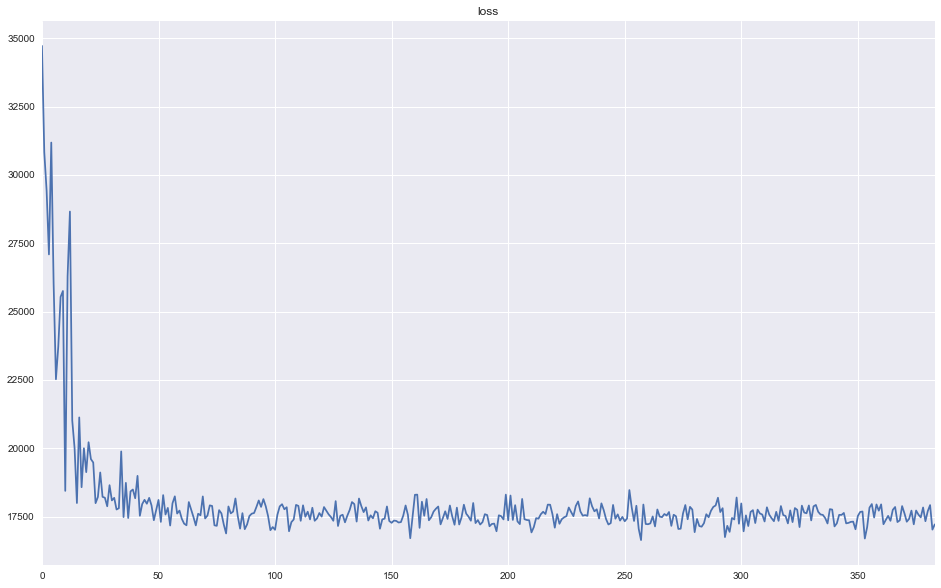

In [9]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

M = 128    # batch size during training
data = generator([X_data, y_data], M)    
y_ph = tf.placeholder(tf.int32, [None])

N = len(X_data)
n_batch = M
n_epoch = 3

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M})
tf.global_variables_initializer().run()

info_dicts = []
for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)
  info_dicts.append(info_dict)
pd.Series([x['loss'] for x in info_dicts]).plot(title='loss');

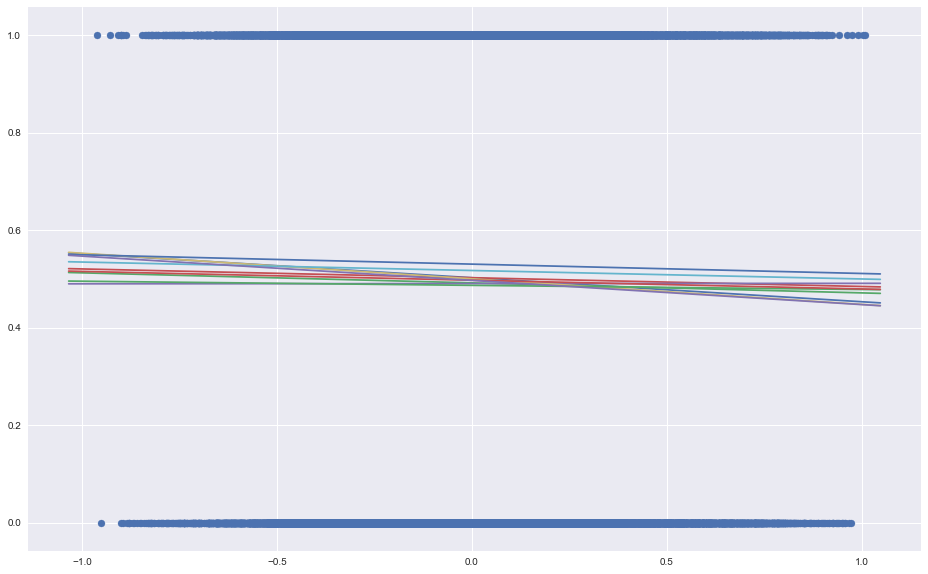

In [10]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

### CRITICISM

In [11]:
y_post = ed.copy(y, {w: qw, b:qb})

### edward v1.4 logloss metric is broken as it accepts predictions instead of logits for tf.binary_cross_entropy
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

The example below showcases this, under maximum uncertainty $logloss$ should be $ -ln(.5) \approx 0.69314$

In [12]:
# see how eval metrics look under example with maximum uncertainy
preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == np.random.randint(0,2,1000)).mean()) #.5 on average
print('logloss:', log_loss(target, preds))
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.5
logloss: 0.69314718056
ed.logloss: 0.721576
tf.doc.logloss 0.72157698418


In [13]:
for nom, y_pst in [('lr',y_post)]:
    for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
        print(nom, sam)
        print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_pst: yy}))
        print("log_likelihood:", ed.evaluate('log_likelihood', data={X: Xx, y_pst: yy}))
        #print("log_loss:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation
        print("\n")

lr INS
binary_acc: 0.533805
log_likelihood: -0.690274


lr OOS
binary_acc: 0.516648
log_likelihood: -0.695905




we'll use our custom function `get_model_probs` (truncation of `ed.evaluate`) to grab the model's probs form a corresponding set of data directly. 

In [14]:
inpreds = get_model_probs(data={X:X_data, y_post:y_data}, n_samples=1000).eval()
ins = eval_model(X_data, y_data, 'ins', probabilities=inpreds)

ospreds = get_model_probs(data={X:X_test, y_post:y_test}, n_samples=1000).eval()
oos = eval_model(X_test, y_test, 'oos', probabilities=ospreds);

ins 
------
acc: 0.533725396063
sk.logloss: 0.688801409347
ed.logloss (corrected): 0.688802
ed.logloss (current): 0.721752
oos 
------
acc: 0.517948205179
sk.logloss: 0.694290892954
ed.logloss (corrected): 0.694291
ed.logloss (current): 0.722545


In [15]:
ins.describe()

,prob,target,guess
count,24996.000000,24996.00000,24996.000000
mean,0.499503,0.50000,0.487878
std,0.055632,0.50001,0.499863
min,0.286832,0.00000,0.000000
25%,0.461386,0.00000,0.000000
50%,0.498270,0.50000,0.000000
75%,0.536518,1.00000,1.000000
max,0.741427,1.00000,1.000000


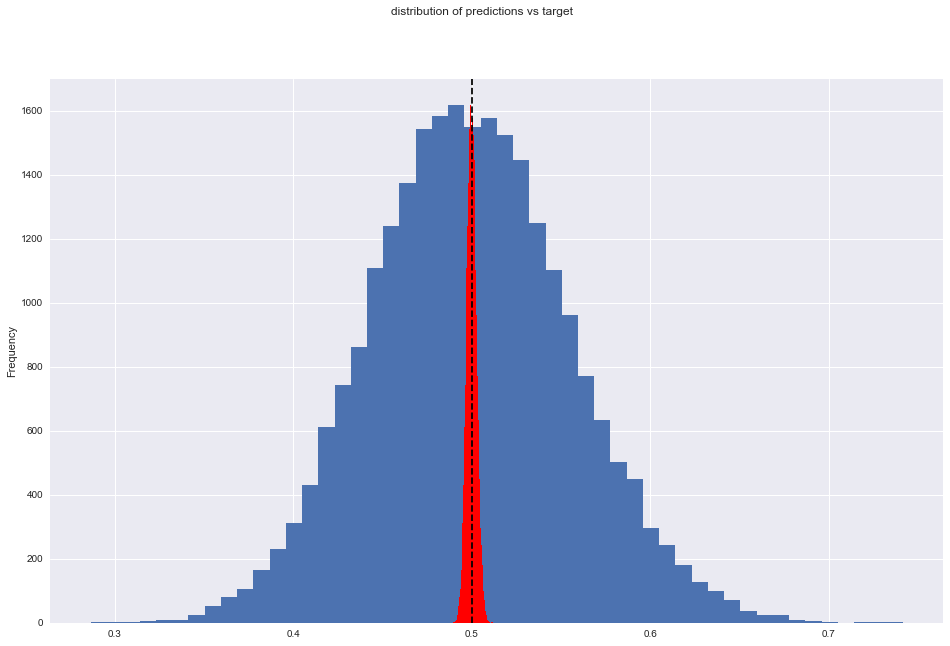

In [16]:
ax = ins['prob'].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins['prob']-.5)*.05)+.5).plot(kind='hist', ax=ax[0], color='red', bins=50); # strinkage around 50%?

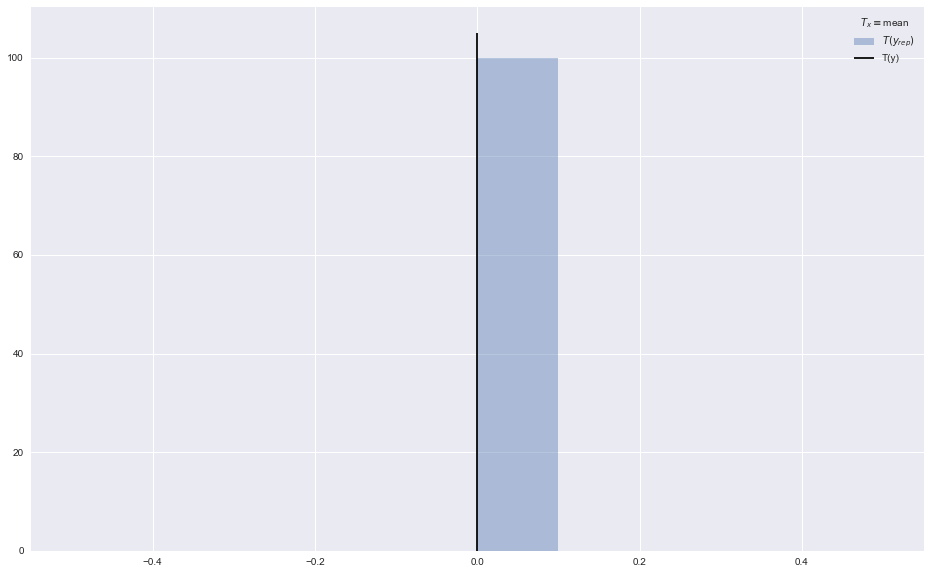

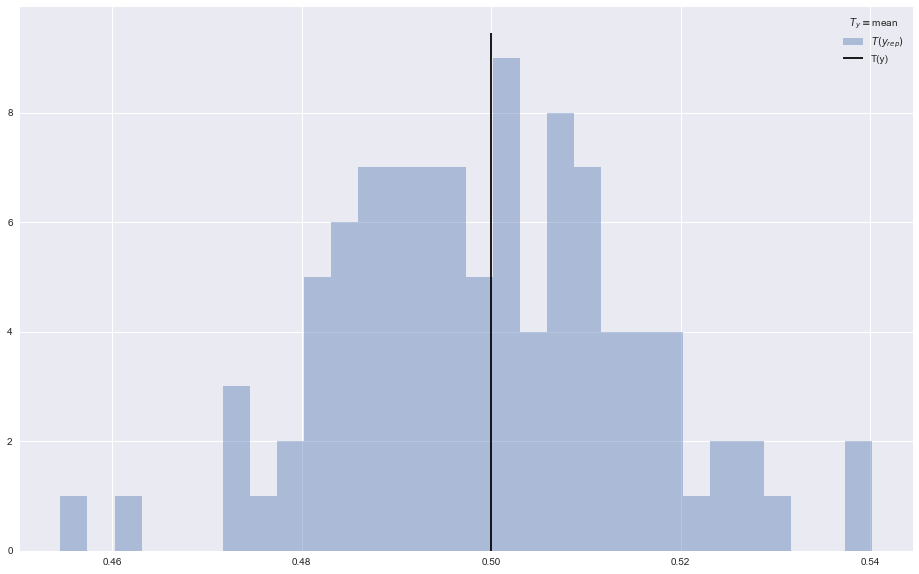

In [17]:
x_post = ed.copy(X, {w: qw, b: qb})
T_xpost = lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32))
y_rep, y1 = ed.ppc(T_xpost, data={x_post: X_data})
ed.ppc_stat_hist_plot(y1[0], y_rep, stat_name=r'$T_x \equiv$mean', bins=10)
plt.show()

T_ypost = lambda xs, zs:  tf.reduce_mean(tf.cast(xs[y_post], tf.float32))
y_rep, y1 = ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[y_post], tf.float32)),data={X: X_data, y_post: y_data})
ed.ppc_stat_hist_plot(y1[0], y_rep, stat_name=r'$T_y \equiv$mean', bins=30)

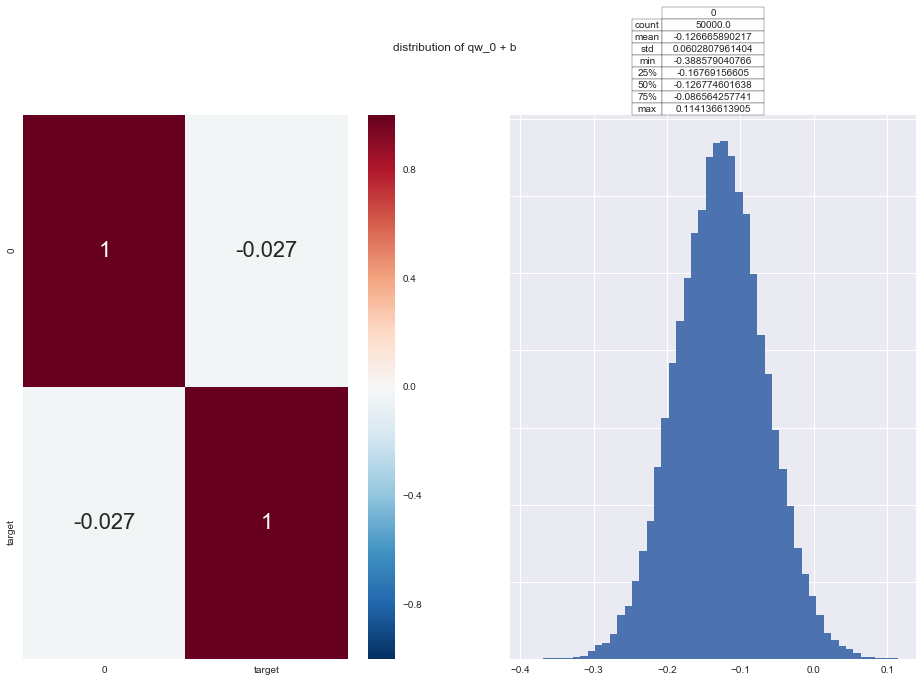

In [18]:
## correlation with target matches sign of mean/median of posterior distribution on parameter
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0]) + np.mean(qb.sample(50000).eval()[:,0]) #shift by beta est.
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0 + b', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [19]:
dcsummary

,0
count,50000.000000
mean,-0.126666
std,0.060281
min,-0.388579
25%,-0.167692
50%,-0.126775
75%,-0.086564
max,0.114137


### Criticism (cont.):  Baseline Comparison (sklearn)

We compare our results againist sklearn's Naive Bayes (BernoulliNB) and Logistic Regression (LogisticRegression).

Note how BernoulliNB is somewhat predictive, though strictly the worse of our other candidate models, all the while LogisticRegression does well on the accuracy prediction but poorly on the out of sample logloss metric.

In [20]:
from sklearn.naive_bayes import BernoulliNB
get_skpreds = lambda dat: clf.predict_proba(dat)[:,1]

print('sk.NAIVE BAYES:')
clf = BernoulliNB()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds, dataset=dataset);
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds, dataset=dataset);

from sklearn import linear_model
print('\nsk.LOGISTIC REGRESSION:')
#regularization_C = 1e3 #lower == more regularization
clf = linear_model.LogisticRegression()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds, dataset=dataset);
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds, dataset=dataset);

print('\nbayesian-forecast logistic regression')
print('--------')
inpreds = get_model_probs(data={X:X_data, y_post:y_data}, n_samples=1000).eval()
ins = eval_model(X_data, y_data, 'ins', probabilities=inpreds, dataset=dataset);

ospreds = get_model_probs(data={X:X_test, y_post:y_test}, n_samples=1000).eval()
oos = eval_model(X_test, y_test, 'oos', probabilities=ospreds, dataset=dataset);

sk.NAIVE BAYES:
ins 
------
acc: 0.533925428068
sk.logloss: 0.68949784753
ed.logloss (corrected): 0.689498
ed.logloss (current): 0.722479
regime1 (0.253) : 0.532008830022 0.690117127231
regime2 (0.252) : 0.530903328051 0.689142422587
regime3 (0.251) : 0.529355608592 0.690419165717
regime4 (0.242) : 0.543937892303 0.688289521737
consistency: 1.0

oos 
------
acc: 0.509349065093
sk.logloss: 0.694645291126
ed.logloss (corrected): 0.694646
ed.logloss (current): 0.723287
regime86 (0.609) : 0.510589394188 0.694829773501
regime87 (0.390) : 0.507416879795 0.694357904388
consistency: 0.0


sk.LOGISTIC REGRESSION:
ins 
------
acc: 0.542606817091
sk.logloss: 0.687249823914
ed.logloss (corrected): 0.68725
ed.logloss (current): 0.721611
regime1 (0.253) : 0.539577420372 0.68800653076
regime2 (0.252) : 0.548177496038 0.68605612636
regime3 (0.251) : 0.532856006364 0.688998190795
regime4 (0.242) : 0.550049554014 0.685885747976
consistency: 1.0

oos 
------
acc: 0.515148485151
sk.logloss: 0.69382751137


Note the subtle difference in OoS in consistency, accurary, and logloss: the edward bayesian probabilistic programming approach actually out performs the sklearn run. Of course at the risk of cherry picking, I'd suggest more empirical trials.

$$ D_{KL}[P(X) \, \Vert \, Q(X)] = \sum_{x \in X} P(x) \, \log \left( \frac{P(x)}{Q(x)} \right) $$

Lets try to explain why theoritically. Our inference technique used was KLqp (reverse KL), which we know makes candidate distribution q 'mode seeking' as opposed to 'mean seeking' in forward KL. Assuming the 'truth' P is a complex function, its not far fetch to think that our model in edward saught one of those modes for our posterior normal distribution of weights, qw. If we imagine that the modes represent particular regimes, that could explain how we did well in that one particular regime.

See an excellent and intuitive write up on forward vs reverse KL divergence here: https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/

![alt text](https://wiseodd.github.io/img/2016-12-21-forward-reverse-kl/forward_kl_bad.png "mode seeking KL")

Below, we also note the distribution of oos predictions has more kurtosis in Edward (ie more confidence) yet it can still achieve this result. Remarkable.

kurt:
 edward    -0.156619
sklearn   -0.238424
dtype: float64


,edward,sklearn
count,10001.000000,10001.000000
mean,0.499030,0.500205
std,0.054748,0.051112
min,0.307891,0.314978
25%,0.461571,0.464905
50%,0.499693,0.500535
75%,0.536113,0.535711
max,0.718052,0.685199


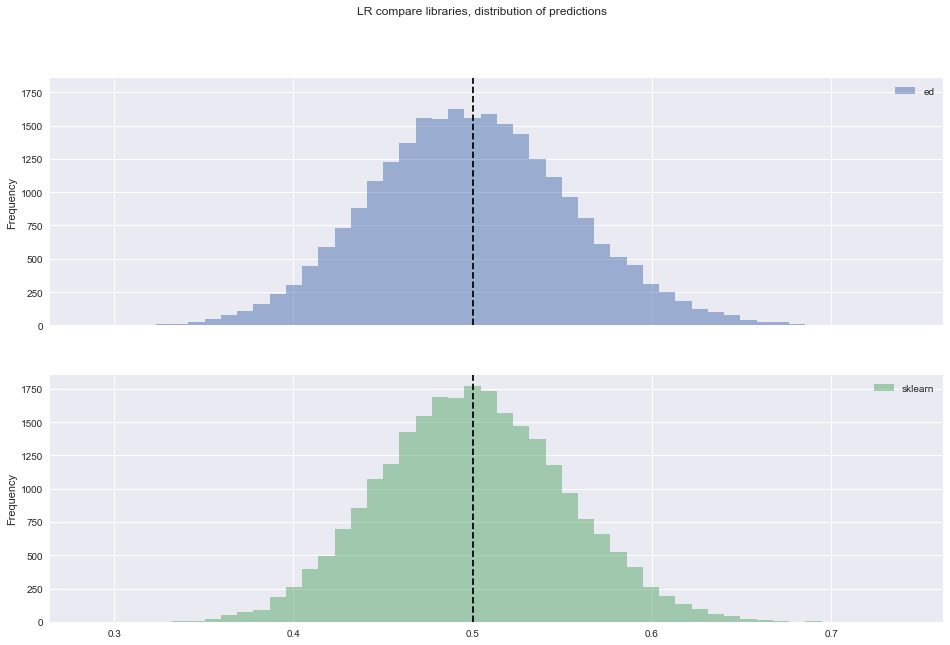

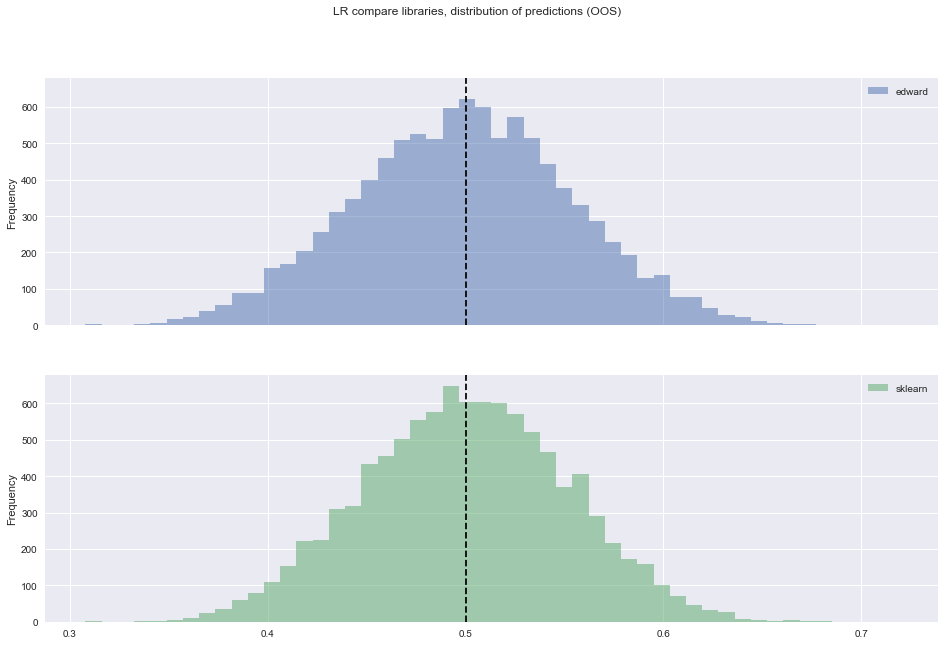

In [21]:
inspreds = pd.DataFrame(
    {
        'sklearn':get_skpreds(X_data),
        'ed':ins['prob']
    })

ax = inspreds.plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='LR compare libraries, distribution of predictions', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
ax[1].axvline(.5, color='k', linestyle='--')

oospreds = pd.DataFrame(
    {
        'sklearn':get_skpreds(X_test),
        'edward':oos['prob'],
    })
ax = oospreds.plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='LR compare libraries, distribution of predictions (OOS)', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
ax[1].axvline(.5, color='k', linestyle='--')

print('kurt:\n', oospreds.kurtosis())
oospreds.describe()

Looping back from criticism -- We'll now model a Bayesian neural network on the same dataset and use Bayesian Model Averaging(BMA) to come up with an ensemble of our candidate model based on the posterior predictive. 

Although the logistic regression is our main focus model for this notebook, we'll also train an complementary Bayesian 2-layer neural network model, in order to allow for more interactions terms.

### Model (2)

In [22]:
X_nn = tf.placeholder(tf.float32, [None , D])

def neural_network(X_nn):
    h = tf.tanh(tf.matmul(X_nn, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

# definds the number of units within each hidden layer (1,2)
lyr1 = 100
lyr2 = 10

# MODEL
with tf.name_scope("model"):
    W_0 = Normal(loc=tf.zeros([D, lyr1]), scale=tf.ones([D, lyr1]), name="W_0")
    W_1 = Normal(loc=tf.zeros([lyr1, lyr2]), scale=tf.ones([lyr1, lyr2]), name="W_1")
    W_2 = Normal(loc=tf.zeros([lyr2, 1]), scale=tf.ones([lyr2, 1]), name="W_2")
    b_0 = Normal(loc=tf.zeros(lyr1), scale=tf.ones(lyr1)*10, name="b_0")
    b_1 = Normal(loc=tf.zeros(lyr2), scale=tf.ones(lyr2)*10, name="b_1")
    b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1)*10, name="b_2")

    y_nn = Bernoulli(logits=(neural_network(X_nn)))

# INFERENCE
with tf.name_scope("posterior"):
    with tf.name_scope("qW_0"):
        qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, lyr1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([D, lyr1]), name="scale")))
    with tf.name_scope("qW_1"):
        qW_1 = Normal(loc=tf.Variable(tf.random_normal([lyr1, lyr2]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([lyr1, lyr2]), name="scale")))
    with tf.name_scope("qW_2"):
        qW_2 = Normal(loc=tf.Variable(tf.random_normal([lyr2, 1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([lyr2, 1]), name="scale")))
    with tf.name_scope("qb_0"):
        qb_0 = Normal(loc=tf.Variable(tf.random_normal([lyr1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([lyr1]), name="scale")))
    with tf.name_scope("qb_1"):
        qb_1 = Normal(loc=tf.Variable(tf.random_normal([lyr2]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([lyr2]), name="scale")))
    with tf.name_scope("qb_2"):
        qb_2 = Normal(loc=tf.Variable(tf.random_normal([1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([1]), name="scale")))

### Inference (2)

Our inference technique here is Importance Weighted Varitional Inference (IWVI). The helper functions to maximize the Evidence Lower bound is tweaked slightly, such that we've moved "log" outside of usual terms compared to a standard VAE.

$$ log(p(x)) >= ELBO = -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [23]:
inference = IWVI({W_0: qW_0, b_0: qb_0,
                  W_1: qW_1, b_1: qb_1,
                  W_2: qW_2, b_2: qb_2}, data={X_nn: X_data, y_nn: y_data})
inference.run(K=5, n_iter=5000, n_print=100)
y_nn_post = ed.copy(y_nn, {W_0: qW_0, b_0: qb_0,
                  W_1: qW_1, b_1: qb_1,
                  W_2: qW_2, b_2: qb_2})

5000/5000 [100%] ██████████████████████████████ Elapsed: 859s | Loss: 17534.531


### Criticism (2)

ins 
------
acc: 0.500160025604
sk.logloss: 0.693152238994
ed.logloss (corrected): 0.693152
ed.logloss (current): 0.724077
regime1 (0.253) : 0.504099653106 0.6931329375
regime2 (0.252) : 0.498256735341 0.693142463789
regime3 (0.251) : 0.494988066826 0.693189106608
regime4 (0.242) : 0.503633961018 0.693143259132
consistency: 0.75

oos 
------
acc: 0.50404959504
sk.logloss: 0.693116681366
ed.logloss (corrected): 0.693117
ed.logloss (current): 0.723494
regime86 (0.609) : 0.504350681333 0.693116753692
regime87 (0.390) : 0.50358056266 0.693116568696
consistency: 1.0



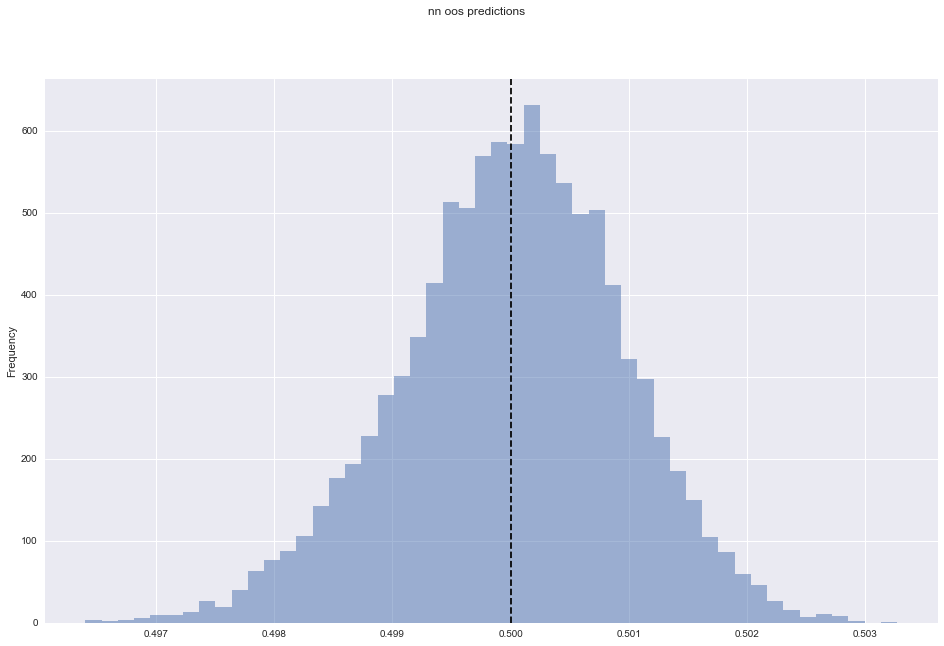

In [24]:
nn_ins_probs = get_model_probs(data={X_nn:X_data, y_nn_post:y_data}, n_samples=1000).eval()
nn_ins_probs -= nn_ins_probs.mean() - .5
nn_ins = eval_model(X_data, y_data, 'ins', probabilities=nn_ins_probs, dataset=dataset)

nn_oos_probs = get_model_probs(data={X_nn:X_test, y_nn_post:y_test}, n_samples=1000).eval()
nn_oos_probs -= nn_oos_probs.mean() - .5
nn_oos = eval_model(X_test, y_test, 'oos', probabilities=nn_oos_probs, dataset=dataset)

ax = nn_oos['prob'].plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='nn oos predictions',bins=50)
ax[0].axvline(.5, color='k', linestyle='--');

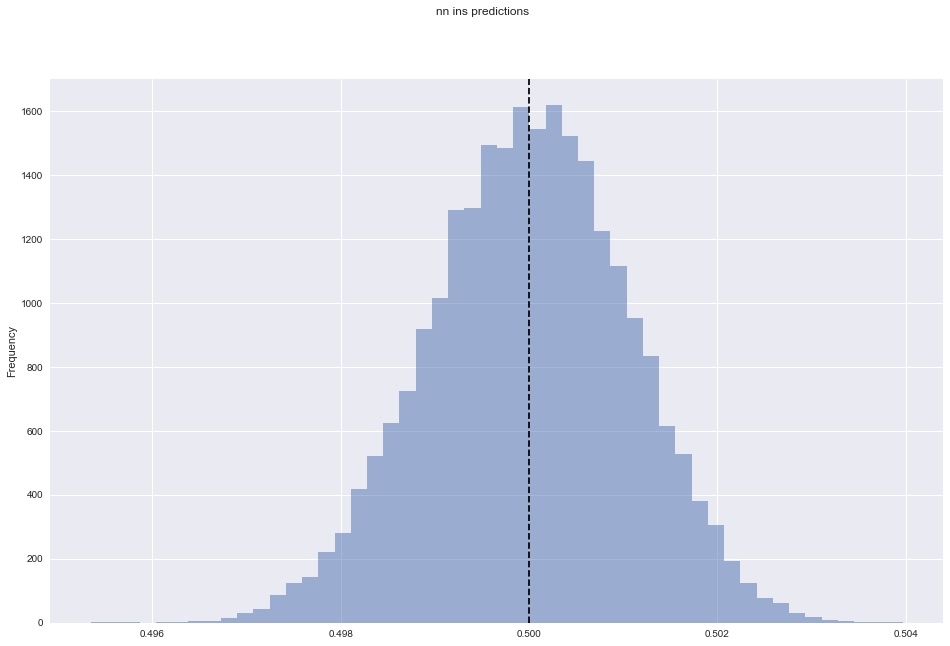

In [25]:
ax = nn_ins['prob'].plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='nn ins predictions',bins=50)
ax[0].axvline(.5, color='k', linestyle='--');

The following is a weighted average of predictions, where each weight for model $m$:
$$weight_m = \exp{(\frac{1}{2}BIC_m)}$$

s.t. $BIC_m = 2 \mathcal{L} + k\log(n) $

and $\mathcal{L}$ is the negative log likelihood

In [26]:
nn_w = np.exp((-2*ed.evaluate("log_lik", data={X_nn:X_data, y_nn_post:y_data}))*.5)
lr_w = np.exp((-2*ed.evaluate("log_lik", data={X:X_data, y_post:y_data}))*.5)

norm_w = lr_w+nn_w

nn_w /= norm_w
lr_w /= norm_w

In [27]:
print("( %.5f * nn_preds + %.5f * lr_preds)" % (nn_w,lr_w))

( 0.40258 * nn_preds + 0.59742 * lr_preds)


Despite the weak though consistent performance of our neural network, notice that consistency has been increased to 1.0 and our acc is quite good. The nn has effectively acted as a shrinkage method to the more perhaps overly confident logistic reg.

In [28]:
bma_oos_probs = ospreds * lr_w + nn_oos_probs * nn_w
eval_model(X_test, y_test, 'oos', probabilities=bma_oos_probs, dataset=dataset);

oos 
------
acc: 0.516448355164
sk.logloss: 0.692378689573
ed.logloss (corrected): 0.692379
ed.logloss (current): 0.722831
regime86 (0.609) : 0.512559514037 0.693064480692
regime87 (0.390) : 0.522506393862 0.691310363817
consistency: 1.0



### Conclusion

Special thanks to [Alp Kucukelbir](http://www.proditus.com/ "Alp Kucukelbir") for his course on probabilistic programming, it was exciting working on a bleeding edge tool in this field. I believe the blackbox segemented approach of `edward` will lead to further adoption of PPL and we'll see more and more interesting examples in the months ahead.

### Potential Future work:
experiment with different model architectures

experiment with different Bayesian Ensemble techniques